In [ ]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt

# Define the current directory if __file__ is not available
current_dir = os.getcwd()  # Gets the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))  # Moves one level up

# Add the parent directory to the Python path
sys.path.insert(0, parent_dir)

from preprocessing import *
from save_and_compare_results import *

In [ ]:
# Define the path to the parent directory
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Move one level up

# 1. Choose the phenotype

In [ ]:
phenotype = "YPD_doublingtime"
#phenotype = "YPDCUSO410MM_40h"

# 2. Preprocess the data

In [ ]:
X = pd.read_pickle(os.path.join(data_dir, f"data/X_matrix_restricted_{phenotype}.pkl"))
Y = pd.read_csv(os.path.join(data_dir, f"data/y_{phenotype}.csv"))

In [3]:
# Preprocess the data
X = X.drop(columns=["Yeast_ID"]).fillna(0)
Y = Y.drop(columns=["Yeast_ID"]).fillna(Y.drop(columns=["Yeast_ID"]).mean())

X, Y = shuffle_dataset(X,Y)

# 3. Run the model

In [ ]:
# Define the hyperparameter grid
param_grid = {
    "alpha": [0.1, 0.2, 0.2],               # Regularization strength
    "l1_ratio": [0.001, 0.05, 0.01, 0.02],  # Mix between L1 (LASSO) and L2 (Ridge)
}

In [5]:
# Initialize ElasticNet
elastic_net = ElasticNet(max_iter=100000, random_state=42)

# GridSearchCV
print("Running hyperparameter tuning...")
grid_search = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    verbose=2,
    n_jobs=-1
)

Running hyperparameter tuning...


In [6]:
# Fit to the data
grid_search.fit(X, Y.values.ravel())

# Get the best model and parameters
best_elastic_net = grid_search.best_estimator_
best_params = grid_search.best_params_
print("\nBest hyperparameters:", best_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...........................alpha=0.1, l1_ratio=0.05; total time=   0.3s
[CV] END ...........................alpha=0.1, l1_ratio=0.05; total time=   0.5s
[CV] END ...........................alpha=0.1, l1_ratio=0.05; total time=   0.2s
[CV] END ...........................alpha=0.1, l1_ratio=0.05; total time=   0.7s
[CV] END ...........................alpha=0.1, l1_ratio=0.05; total time=   0.7s
[CV] END ...........................alpha=0.1, l1_ratio=0.01; total time=   1.0s
[CV] END ...........................alpha=0.1, l1_ratio=0.01; total time=   1.5s
[CV] END ...........................alpha=0.1, l1_ratio=0.01; total time=   1.2s
[CV] END ...........................alpha=0.1, l1_ratio=0.01; total time=   1.0s
[CV] END ...........................alpha=0.1, l1_ratio=0.02; total time=   0.5s
[CV] END ...........................alpha=0.1, l1_ratio=0.02; total time=   0.5s
[CV] END ...........................alpha=0.1, l

In [7]:
# Evaluate the best model
y_pred = best_elastic_net.predict(X)
r2 = r2_score(Y, y_pred)
mse = mean_squared_error(Y, y_pred)
print(f"\nR² Score: {r2:.4f}, Mean Squared Error: {mse:.4f}")


R² Score: 0.2576, Mean Squared Error: 0.0372


# 4. Only plot the top 20 features


Top 20 Features Impacting YPD Doubling Time:
               Feature  Importance
3982       YCR108C_CNV    0.016975
4199       YMR326C_CNV    0.016194
4212       YNR072W_CNV    0.015054
3884  YPR196W_312_T->I    0.014227
3308  YMR006C_342_F->V    0.011097
3192   YLR236C_49_F->L    0.010330
2464   YIR020C_92_W->*    0.010016
541    YBR298C_58_I->T    0.009882
2751  YJR149W_357_S->N    0.009845
3141  YLR141W_244_V->I    0.009680
420   YBR298C_122_A->S    0.009587
4083       YHR043C_CNV    0.009528
3901  YPR196W_387_G->V    0.009447
1020   YDL241W_49_F->V    0.009407
4065       YGR074W_CNV    0.009391
2653   YJL151C_90_I->V    0.008894
352   YBR093C_104_G->S    0.008871
2001   YGR291C_25_F->L    0.008871
455   YBR298C_272_K->R    0.008727
4179     YML057C-A_CNV    0.008567


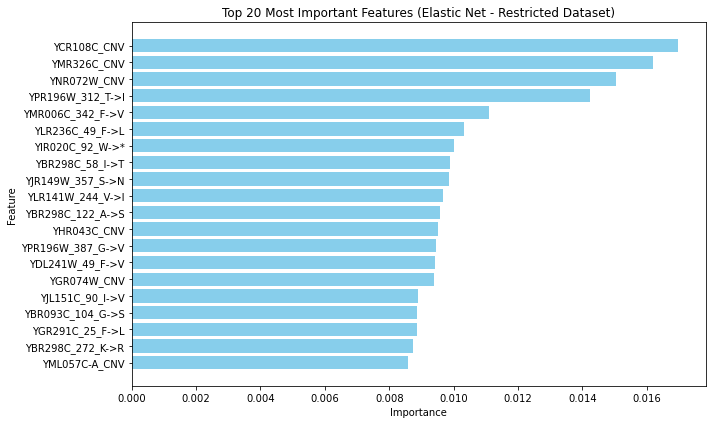

In [ ]:
feature_importances = best_elastic_net.coef_
features = X.columns

# Create a DataFrame for feature importance
feature_importances_df = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Select the top 20 most important features
top_features = feature_importances_df.head(20)

# Display the top features in the console
print("\nTop 20 Features Impacting YPD Doubling Time:")
print(top_features)

# Plot the top 20 features importance
plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 20 Most Important Features (Elastic Net - Restricted Dataset)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [12]:
save_feature_importance(
        features=features,
        importance_scores=feature_importances,
        method="ElasticNet",
        model_name="mutations"
    )

Feature importance saved to ../results/mutations_ElasticNet_importance.csv


# 5. Model features importance

Saving ElasticNet feature importances...
Feature importance saved to ../results/ElasticNet_model_importance.csv
Displaying top 10 features...

Top 10 Features Impacting YPD Doubling Time:
               Feature  Importance
3982       YCR108C_CNV    0.016975
4199       YMR326C_CNV    0.016194
4212       YNR072W_CNV    0.015054
3884  YPR196W_312_T->I    0.014227
3308  YMR006C_342_F->V    0.011097
3192   YLR236C_49_F->L    0.010330
2464   YIR020C_92_W->*    0.010016
541    YBR298C_58_I->T    0.009882
2751  YJR149W_357_S->N    0.009845
3141  YLR141W_244_V->I    0.009680


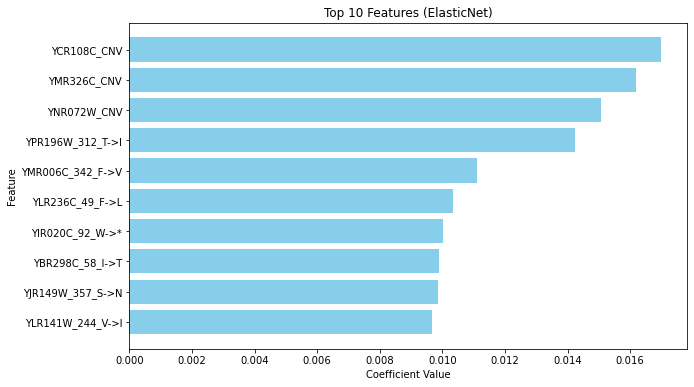

In [10]:
# Save feature importance from ElasticNet
print("Saving ElasticNet feature importances...")
save_feature_importance(
    features=X.columns,
    importance_scores=best_elastic_net.coef_,
    method="model",
    model_name="ElasticNet"
)

# Display and plot the top 10 features
print("Displaying top 10 features...")
feature_importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_elastic_net.coef_
}).sort_values(by="Importance", ascending=False)

top_features = feature_importances_df.head(10)

print("\nTop 10 Features Impacting YPD Doubling Time:")
print(top_features)

plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Top 10 Features (ElasticNet)")
plt.gca().invert_yaxis()
plt.show()

# 6. SHAP features importance

Calculating SHAP values for ElasticNet...
Saving SHAP feature importances for ElasticNet...
Feature importance saved to ../results/ElasticNet_SHAP_importance.csv
Generating SHAP summary plots for ElasticNet...


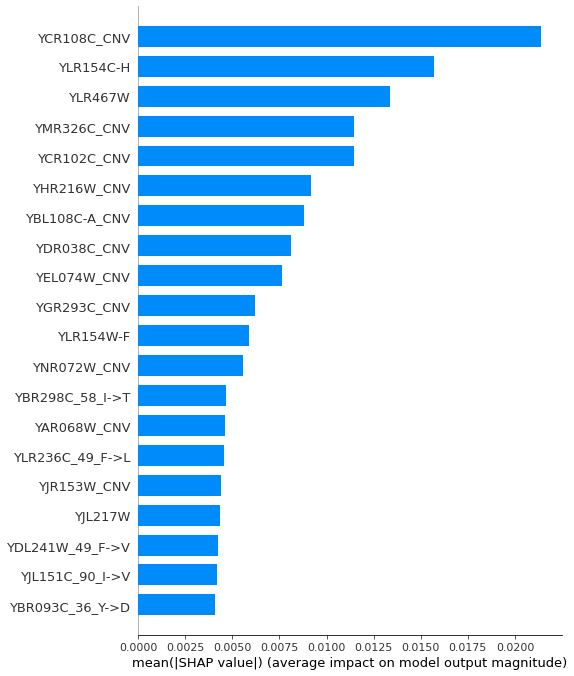

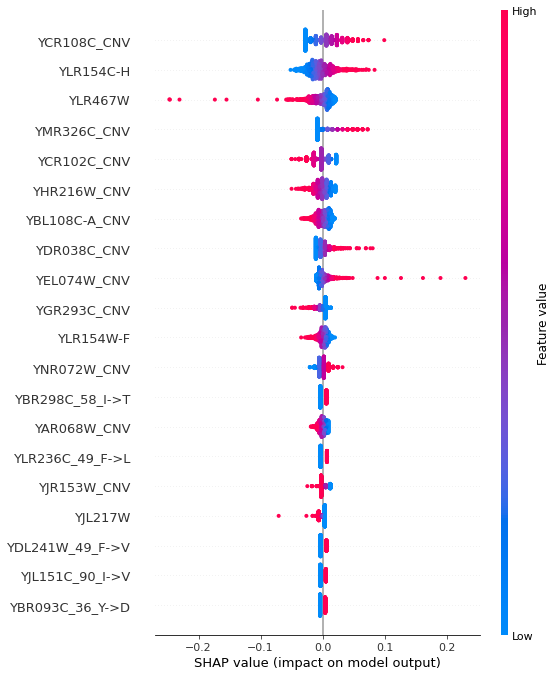

In [11]:
# Create a SHAP explainer for ElasticNet
explainer = shap.Explainer(best_elastic_net, X)

# Calculate SHAP values
print("Calculating SHAP values for ElasticNet...")
shap_values = explainer(X)

# Save SHAP feature importance
shap_mean_importance = np.abs(shap_values.values).mean(axis=0)

print("Saving SHAP feature importances for ElasticNet...")
save_feature_importance(
    features=X.columns,
    importance_scores=shap_mean_importance,
    method="SHAP",
    model_name="ElasticNet"
)

# Generate SHAP summary plots
print("Generating SHAP summary plots for ElasticNet...")
shap.summary_plot(shap_values, X, plot_type="bar")
shap.summary_plot(shap_values, X)